In [1]:
# use if autocompletion is not working
%config Completer.use_jedi = False

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import (CountVectorizer)
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
from os import getcwd, path
import os
from tqdm.autonotebook import tqdm
from matplotlib.ticker import MaxNLocator
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Gensim
import gensim
import gensim.corpora as corpora

# plotting
from matplotlib import pyplot as plt

import json
from typing import Dict

<ipython-input-4-dc8f9ac616a0>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from modern_slavery_registry.utils import (
    dump_pickle,
    load_pickle)
from modern_slavery_registry import text_parser

In [6]:
RANDOM_STATE = 40

## Loading data with final cleaned statements

In [7]:
PROJECT_PATH = getcwd().replace(
    path.basename(getcwd()), "")
DATA_PATH = path.join(PROJECT_PATH, "data")
MODEL_SAVE_PATH = path.join(PROJECT_PATH, "models")
SHEETS_PATH = path.join(DATA_PATH, "sheets")
PICKLE_PATH = path.join(DATA_PATH, "pickles")

In [8]:
data = pd.read_excel(f"{SHEETS_PATH}\\subset_data.xlsx")
data.fillna("#NA", inplace=True)
data = data[["URL", "final_statement_cleaned"]]
n_sentences = len(data)
print(f"Found {n_sentences} non-NA statements")

Found 9993 non-NA statements


In [9]:
data.head()

,URL,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 km sh foor eum hold europe ltd 200 alder...
1,https://1spatial.com/who-we-are/legal/modern-s...,home solution government boundary law enforcem...
2,https://www.shazans.com/slavery-and-human-traf...,shazans shazan food continue monitor covid 19 ...
3,https://www.business-humanrights.org/sites/def...,28 2019 2018 statement make pursuant sec 54 20...
4,https://www.2agriculture.com/wp-content/upload...,fh 2015 introduction uk act require business s...


## Generating NGRAMS explicitly, not using Gensim NGRAMS - works like a black-box

In [20]:
NGRAMS=(1,2)
ngrams_from_corpus = text_parser.generate_ngrams(
    data["final_statement_cleaned"].values, 
    ngrams=NGRAMS)

100%|████████████████████████████████████████████████████████████████████████████| 9993/9993 [00:03<00:00, 2721.58it/s]


In [21]:
print(ngrams_from_corpus[0][:500])

['66', '99', 'km', 'sh', 'foor', 'eum', 'hold', 'europe', 'ltd', '200', 'aldersgate', 'street', 'london', 'ecia', '4hd', 'tel', '020', '7382', '6500', 'mail', 'keulongen', 'uk', 'kline', 'com', 'transparency', 'statement', 'crane', 'lineure', 'eee', 'publish', '22', 'march', '2019', '2015', 'require', 'large', 'entity', 'carry', 'business', 'publish', 'detail', 'effort', 'combat', 'human', 'traffic', 'relates', 'action', 'activity', 'financial', 'year', 'april', '2018', '31', 'part', 'ship', 'industry', 'group', 'recognize', 'responsibility', 'take', 'robust', 'approach', 'absolutely', 'commit', 'prevent', 'corporate', 'ensure', 'supply', 'chain', 'free', 'organizational', 'structure', 'global', 'entity', 'headquarter', 'tokyo', 'japan', 'network', 'office', 'around', 'globe', 'include', 'united', 'kingdom', 'comprise', 'bulk', 'lng', 'polar', 'unit', 'include', 'car', 'carrier', 'dry', 'management', 'operation', 'train', 'relevant', 'policy', 'charter', 'conduct', 'company', 'adhere',

Generating vocab from `NGRAMS`

In [22]:
term_freq, doc_freq = text_parser.compute_term_doc_freq(
    ngrams_from_corpus=ngrams_from_corpus, 
    sort=True, 
    descending=True)

9993it [00:08, 1196.50it/s]


In [23]:
print(f"Vocab size: {len(term_freq)}") # without padding last ngrams word in each sentence

Vocab size: 1264192


In [29]:
ngram_stat_table = pd.DataFrame(
    {"term_freq": term_freq.values(), "doc_freq": doc_freq.values()})
ngram_stat_table.describe()

,term_freq,doc_freq
count,1.264192e+06,1.264192e+06
mean,5.070243e+00,4.820556e+00
std,9.578622e+01,7.809273e+01
min,1.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00
50%,1.000000e+00,1.000000e+00
75%,2.000000e+00,2.000000e+00
max,1.849500e+04,9.501000e+03


Selecting vocab of interests

In [30]:
MIN_DF = 10 # ngrams present in atleast 10 docs out of total
MAX_DF = 1000  # consider ngrams present in atmost 1000 docs out of total
ngram_covered = len(ngram_stat_table[ngram_stat_table["doc_freq"].between(MIN_DF, MAX_DF)])
print(f"{NGRAMS}-grams vocab size with doc frequency ({MIN_DF: .3f}, {MAX_DF: .3f}): "
      f"{ngram_covered}")
print(f"{NGRAMS}-grams vocab size with doc frequency ({MIN_DF: .3f}, {MAX_DF: .3f}): "
      f"{ngram_covered*100/len(doc_freq):.3f} %")

(1, 2)-grams vocab size with doc frequency ( 10.000,  1000.000): 48465
(1, 2)-grams vocab size with doc frequency ( 10.000,  1000.000): 3.834 %


## Preparing data for Gensim model

In [31]:
count_vect = CountVectorizer(ngram_range=NGRAMS, min_df=MIN_DF, max_df=MAX_DF)
X = count_vect.fit_transform(data["final_statement_cleaned"].values) 
print(f"shape: {X.shape}")

shape: (9993, 48465)


In [32]:
word2idx = count_vect.vocabulary_
idx2word = {idx: word for word, idx in word2idx.items()}

data_for_model = []
for row in tqdm(X.toarray()):
    idxs = np.where(row > 0)
    data_for_model.append([(idx, row[idx]) for idx in idxs[0]])

  0%|          | 0/9993 [00:00<?, ?it/s]

In [34]:
N_TOPICS = (2, 201)
LDA_MODELS = {}
model_name_template = "sklearn_bigrams_gensim_lda2"

In [35]:
%%time
# Build LDA model

for n in tqdm(range(*N_TOPICS)):
    LDA_MODELS[n] = gensim.models.ldamodel.LdaModel(
        corpus=data_for_model,
        id2word=idx2word, 
        num_topics=n,
        update_every=1,
        chunksize=1000,
        passes=1,
        alpha='auto',
        per_word_topics=True,
        iterations=50,
        random_state=RANDOM_STATE)
    dump_pickle(
        obj=LDA_MODELS[n], filename=f"{model_name_template}_{n}_topics", path=MODEL_SAVE_PATH)

  0%|          | 0/199 [00:00<?, ?it/s]

Wall time: 5h 9min 35s


In [37]:
def print_topic_keywords(
    lda_model: gensim.models.ldamodel.LdaModel,
    num_words: int=20,
    num_topics: int=-1, 
    print_: bool=False)->Dict[int, str]:
    topics_dict = {}
    for topic in lda_model.print_topics(num_words=num_words, num_topics=num_topics):
        topics_dict[topic[0]] = topic[1]
        if print_:
            print(f"{topic[0]}: {topic[1:]}")
            print()
            
    return topics_dict

In [38]:
topics = {n_topic: print_topic_keywords(LDA_MODELS[n_topic]) for n_topic in tqdm(range(*N_TOPICS))}

  0%|          | 0/199 [00:00<?, ?it/s]

In [47]:
with open(path.join(DATA_PATH, f"{model_name_template}_topics.json"), "w") as f:
    json.dump(topics, f)

In [39]:
a = print_topic_keywords(LDA_MODELS[10], print_=True)

0: ('0.002*"compact" + 0.002*"asset" + 0.002*"un" + 0.002*"uphold" + 0.002*"fund" + 0.001*"regulate" + 0.001*"invest" + 0.001*"united nation" + 0.001*"channel" + 0.001*"2015 act" + 0.001*"investor" + 0.001*"global compact" + 0.001*"consideration" + 0.001*"european" + 0.001*"bank" + 0.001*"authorize" + 0.001*"internationally" + 0.001*"rule" + 0.001*"universal" + 0.001*"24"',)

1: ('0.004*"france" + 0.003*"germany" + 0.003*"italy" + 0.003*"netherlands" + 0.003*"spain" + 0.003*"singapore" + 0.002*"australia" + 0.002*"canada" + 0.002*"kong" + 0.002*"belgium" + 0.002*"africa" + 0.002*"hong kong" + 0.002*"sweden" + 0.002*"hong" + 0.002*"india" + 0.002*"japan" + 0.002*"switzerland" + 0.002*"denmark" + 0.002*"republic" + 0.002*"poland"',)

2: ('0.001*"raise awareness" + 0.001*"accordance section" + 0.001*"whilst" + 0.001*"sedex" + 0.001*"exposure" + 0.001*"retailer" + 0.001*"spend" + 0.001*"july" + 0.001*"division" + 0.001*"prevent human" + 0.001*"month" + 0.001*"roll" + 0.001*"recruit" + 0.00

## Computing log perpexity w.r.t. to number of topics

In [40]:
LOG_PERPLEXITIES = {}
for n in tqdm(range(*N_TOPICS)):
    if n not in LOG_PERPLEXITIES.keys():
        lda_model = load_pickle(filename=f"{model_name_template}_{n}_topics", path=MODEL_SAVE_PATH)
        LOG_PERPLEXITIES[n] = lda_model.log_perplexity(data_for_model)

  0%|          | 0/199 [00:00<?, ?it/s]

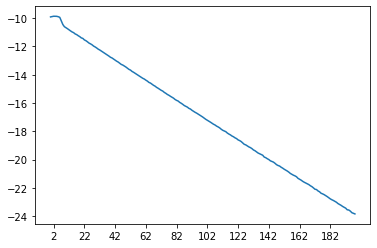

In [41]:
plt.plot(list(LOG_PERPLEXITIES.values()))
plt.xticks(range(*N_TOPICS, 20))
plt.show()

In [44]:
dump_pickle(
    LOG_PERPLEXITIES, 
    filename=f"{model_name_template}_log_perplexities_{N_TOPICS[0]}_{N_TOPICS[1]}_topics", 
    path=PICKLE_PATH)

In [45]:
# loading pre-computed log-perplexities
LOG_PERPLEXITIES = load_pickle(
    path.join(
        PICKLE_PATH, 
        f"{model_name_template}_log_perplexities_{N_TOPICS[0]}_{N_TOPICS[1]}_topics"))

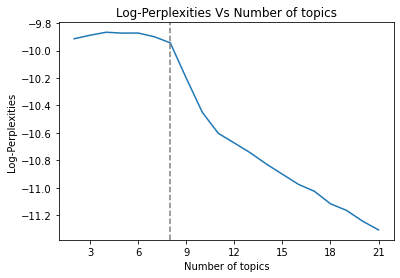

In [46]:
MAX_N_TOPIC = 20
_, ax = plt.subplots()
ax.plot(
    [i for i in range(*N_TOPICS)][:MAX_N_TOPIC], 
    list(LOG_PERPLEXITIES.values())[:MAX_N_TOPIC])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Log-Perplexities Vs Number of topics")
ax.set_xlabel("Number of topics")
ax.set_ylabel("Log-Perplexities")
ax.axvline(x=8, linestyle="dashed", color="grey")
plt.show()

From above, we can say <b>8</b> as correct number of topics for LDA on bigrams.